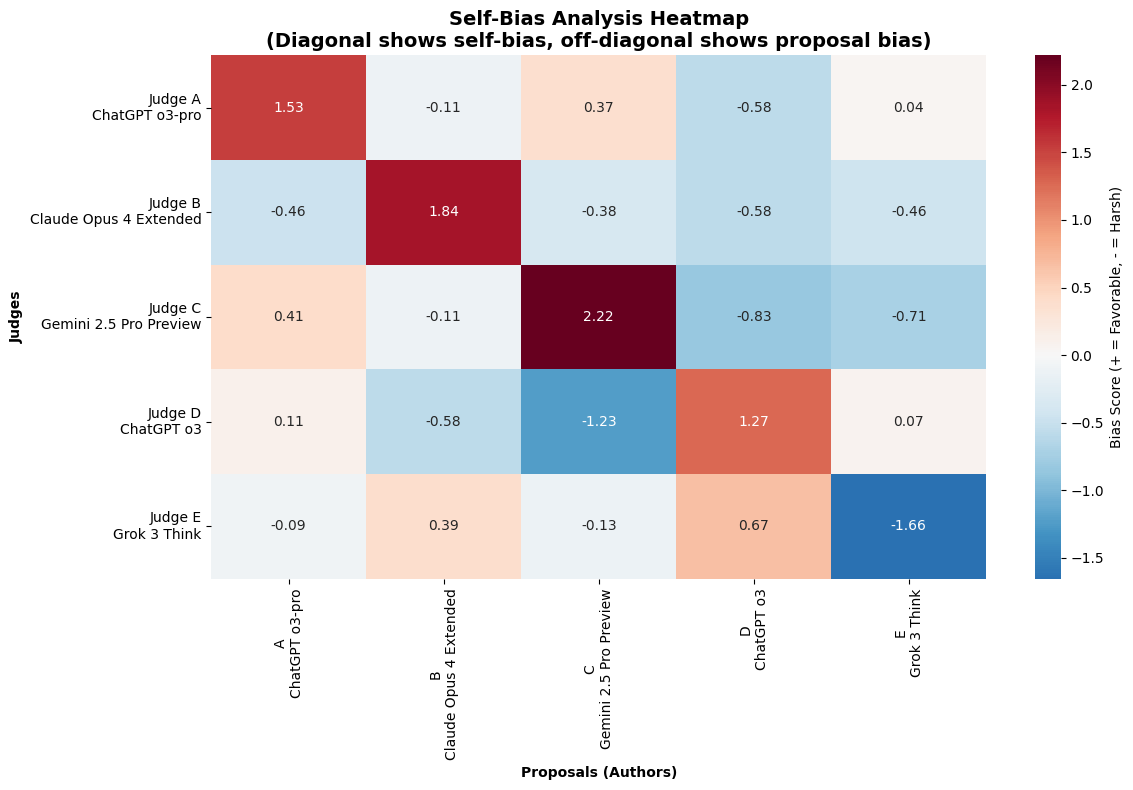

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data organization
judges = ['A', 'B', 'C', 'D', 'E']
proposals = ['A', 'B', 'C', 'D', 'E']
model_names = {
    'A': 'ChatGPT o3-pro',
    'B': 'Claude Opus 4 Extended',
    'C': 'Gemini 2.5 Pro Preview',
    'D': 'ChatGPT o3',
    'E': 'Grok 3 Think'
}

# Organized scoring data (average across all criteria for simplicity)
scores_matrix = np.array([
    [9.125, 8.625, 8.75, 7.0, 6.0],    # Judge A scores
    [8.625, 9.125, 8.0, 7.0, 5.5],     # Judge B scores
    [9.5, 8.625, 9.75, 6.75, 5.25],    # Judge C scores
    [9.2, 8.15, 7.15, 8.9, 6.025],     # Judge D scores
    [9.0, 9.125, 8.25, 8.25, 7.0]      # Judge E scores
])

# Calculate self-bias (diagonal vs off-diagonal)
self_scores = np.diag(scores_matrix)
avg_others_scores = np.array([
    np.mean([scores_matrix[i,j] for j in range(5) if i != j])
    for i in range(5)
])

bias_matrix = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        if i == j:
            bias_matrix[i,j] = self_scores[i] - avg_others_scores[i]
        else:
            bias_matrix[i,j] = scores_matrix[i,j] - np.mean(scores_matrix[:,j])

plt.figure(figsize=(12, 8))
sns.heatmap(bias_matrix,
            xticklabels=[f"{p}\n{model_names[p]}" for p in proposals],
            yticklabels=[f"Judge {j}\n{model_names[j]}" for j in judges],
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Bias Score (+ = Favorable, - = Harsh)'})

plt.title('Self-Bias Analysis Heatmap\n(Diagonal shows self-bias, off-diagonal shows proposal bias)',
          fontsize=14, fontweight='bold')
plt.xlabel('Proposals (Authors)', fontweight='bold')
plt.ylabel('Judges', fontweight='bold')
plt.tight_layout()
plt.show()

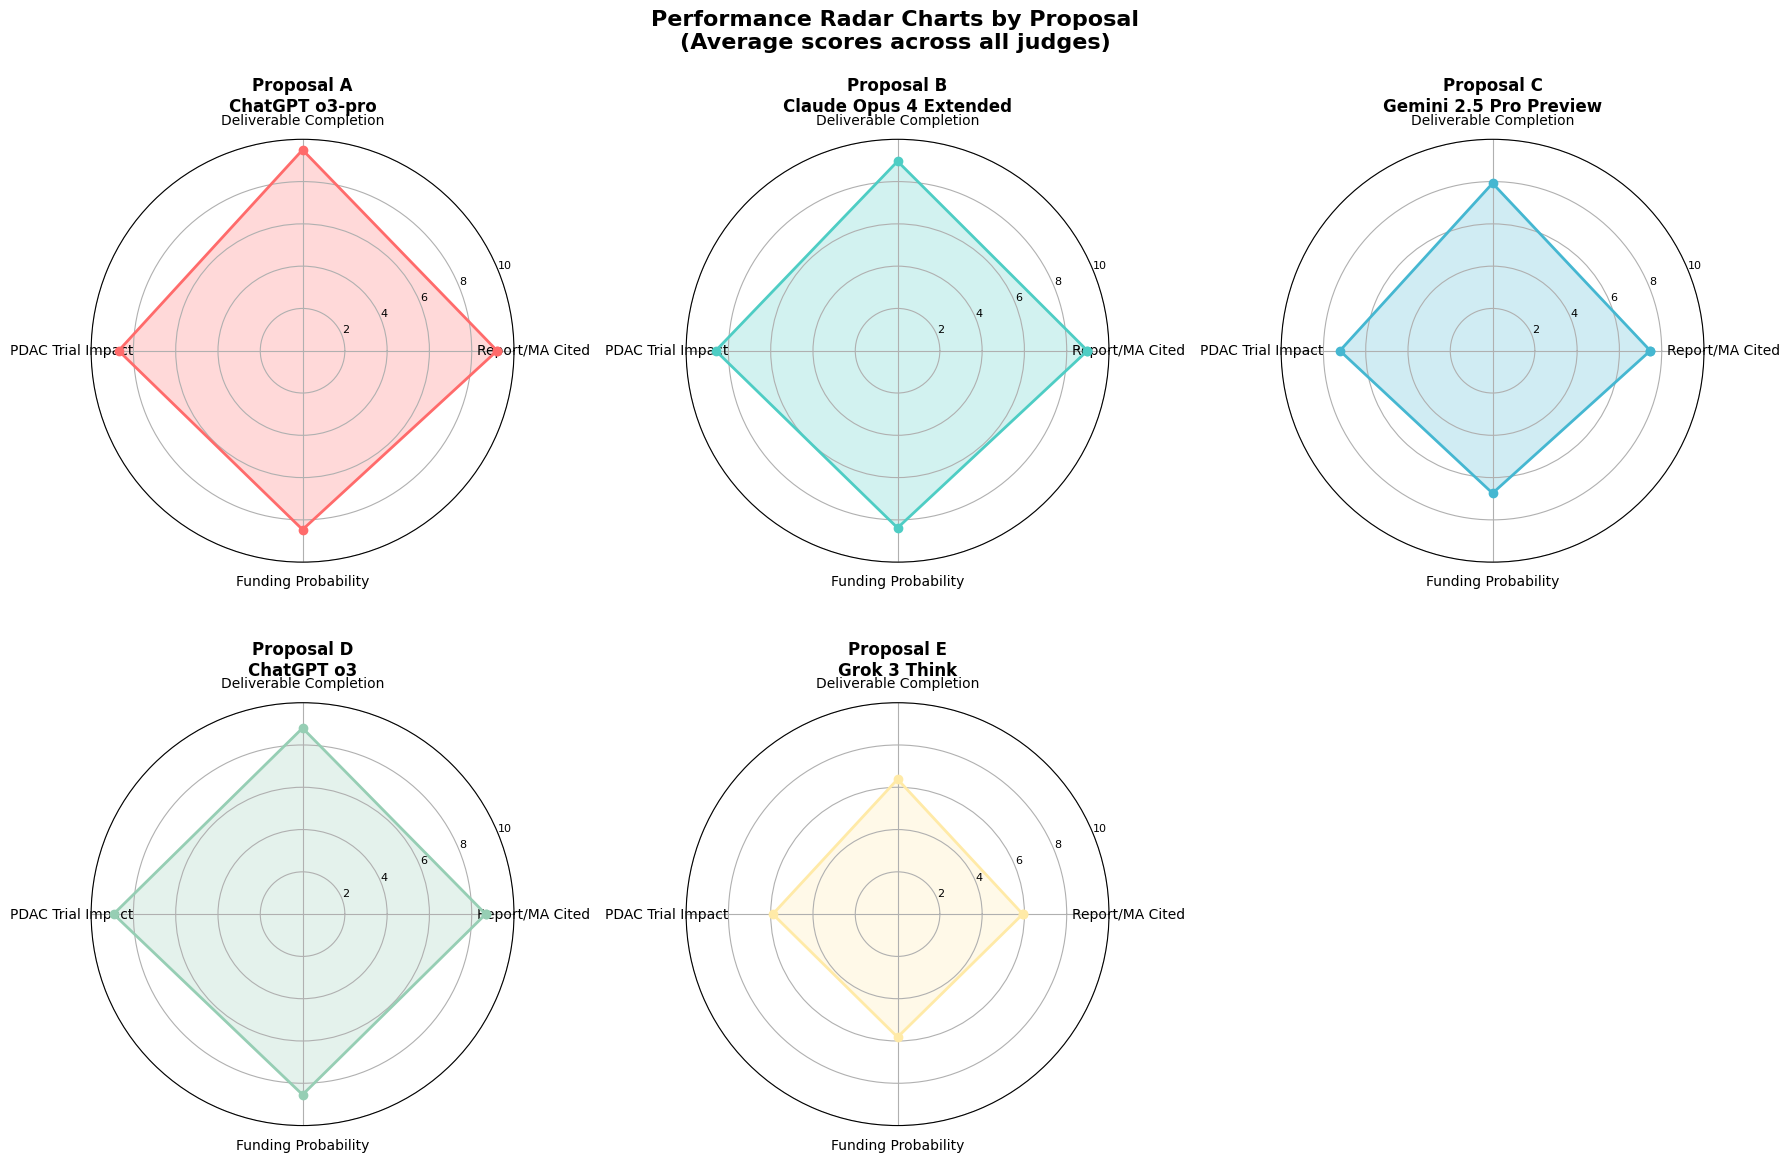

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi

# Detailed scoring data by criteria
criteria = ['Report/MA Cited', 'Deliverable Completion', 'PDAC Trial Impact', 'Funding Probability']

# Average scores across all judges for each proposal
proposal_scores = {
    'A': [9.2, 9.5, 8.7, 8.46],
    'B': [8.98, 8.96, 8.6, 8.38],
    'C': [7.46, 7.92, 7.22, 6.74],
    'D': [8.66, 8.8, 8.94, 8.54],
    'E': [5.92, 6.38, 5.9, 5.82]
}

# Create subplot for each proposal
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for idx, (proposal, scores) in enumerate(proposal_scores.items()):
    ax = axes[idx]

    # Angles for each criteria
    angles = [n / float(len(criteria)) * 2 * pi for n in range(len(criteria))]
    angles += angles[:1]  # Complete the circle

    # Add scores
    scores += scores[:1]  # Complete the circle

    # Plot
    ax.plot(angles, scores, 'o-', linewidth=2, label=f'Proposal {proposal}',
            color=colors[idx])
    ax.fill(angles, scores, alpha=0.25, color=colors[idx])

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(criteria, fontsize=10)
    ax.set_ylim(0, 10)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_yticklabels(['2', '4', '6', '8', '10'], fontsize=8)
    ax.grid(True)

    ax.set_title(f'Proposal {proposal}\n{model_names[proposal]}',
                 fontsize=12, fontweight='bold', pad=20)

# Remove empty subplot
axes[5].remove()

plt.suptitle('Performance Radar Charts by Proposal\n(Average scores across all judges)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

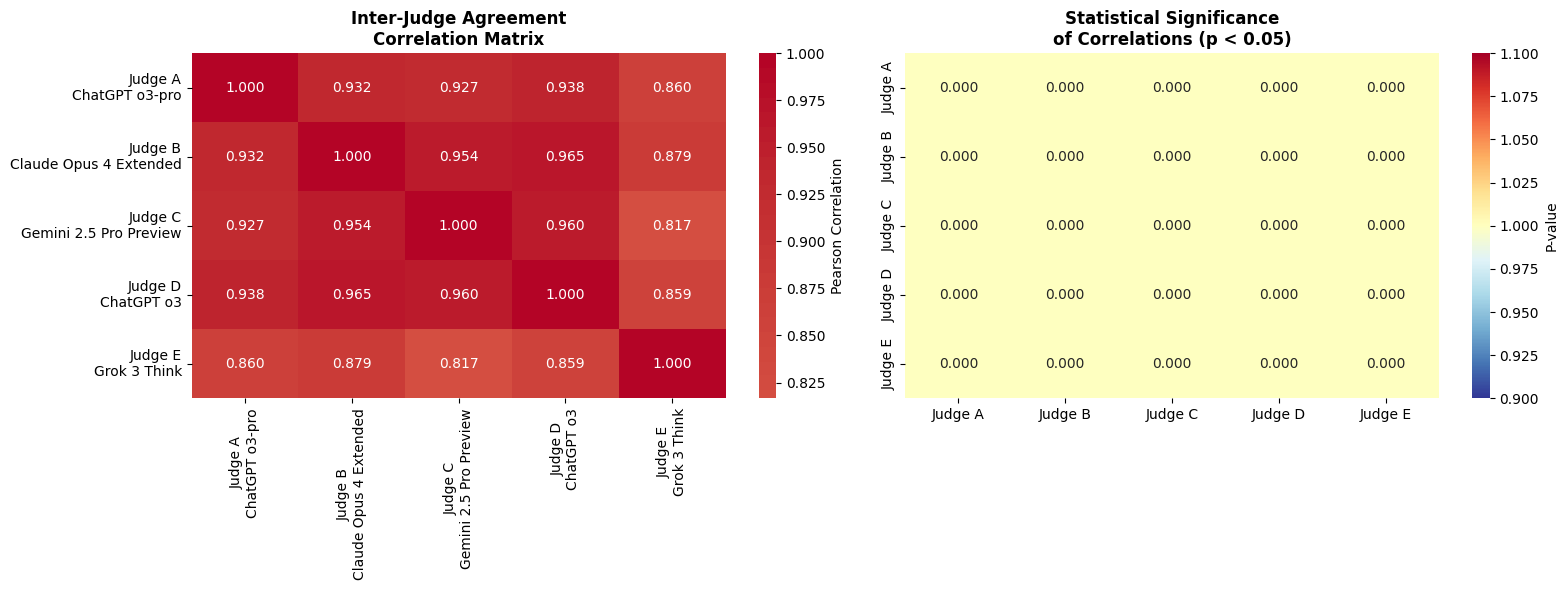

Inter-Judge Agreement Summary:
----------------------------------------
Average inter-judge correlation: 0.909
Highest agreement: 0.965
Lowest agreement: 0.817


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Flatten all scores by judge for correlation analysis
judge_scores = {
    'A': [9.5, 9.5, 9.0, 8.5, 9.0, 9.0, 8.5, 9.0, 8.5, 9.0, 9.5, 8.0, 7.5, 8.0, 7.5, 7.0, 6.0, 6.5, 6.0, 5.5],
    'B': [8.5, 9.5, 8.5, 8.0, 9.5, 9.0, 9.5, 8.5, 8.0, 8.5, 8.0, 7.5, 7.0, 7.5, 7.0, 6.5, 5.5, 6.0, 5.5, 5.0],
    'C': [9.5, 10.0, 9.0, 9.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 8.5, 8.0, 7.0, 8.5, 6.0, 5.5, 5.0, 6.0, 5.0, 5.0],
    'D': [9.5, 9.5, 9.0, 8.8, 9.0, 9.0, 9.2, 8.4, 8.4, 8.3, 8.0, 7.9, 7.3, 7.6, 7.1, 6.7, 6.1, 6.4, 6.0, 5.6],
    'E': [9.0, 9.5, 9.0, 8.5, 9.0, 9.0, 9.0, 9.5, 8.5, 8.5, 8.5, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 7.0, 7.0, 7.0]
}

# Calculate correlation matrix
correlation_matrix = np.zeros((5, 5))
p_values = np.zeros((5, 5))

judge_names = list(judge_scores.keys())
for i, judge1 in enumerate(judge_names):
    for j, judge2 in enumerate(judge_names):
        if i == j:
            correlation_matrix[i, j] = 1.0
            p_values[i, j] = 0.0
        else:
            corr, p_val = pearsonr(judge_scores[judge1], judge_scores[judge2])
            correlation_matrix[i, j] = corr
            p_values[i, j] = p_val

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
sns.heatmap(correlation_matrix,
            xticklabels=[f"Judge {j}\n{model_names[j]}" for j in judge_names],
            yticklabels=[f"Judge {j}\n{model_names[j]}" for j in judge_names],
            annot=True, fmt='.3f', cmap='coolwarm', center=0,
            ax=ax1, cbar_kws={'label': 'Pearson Correlation'})
ax1.set_title('Inter-Judge Agreement\nCorrelation Matrix', fontweight='bold')

# Significance heatmap
significance = p_values < 0.05
sns.heatmap(significance.astype(int),
            xticklabels=[f"Judge {j}" for j in judge_names],
            yticklabels=[f"Judge {j}" for j in judge_names],
            annot=p_values, fmt='.3f', cmap='RdYlBu_r',
            ax=ax2, cbar_kws={'label': 'P-value'})
ax2.set_title('Statistical Significance\nof Correlations (p < 0.05)', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Inter-Judge Agreement Summary:")
print("-" * 40)
mean_correlation = np.mean(correlation_matrix[np.triu_indices(5, k=1)])
print(f"Average inter-judge correlation: {mean_correlation:.3f}")
print(f"Highest agreement: {np.max(correlation_matrix[np.triu_indices(5, k=1)]):.3f}")
print(f"Lowest agreement: {np.min(correlation_matrix[np.triu_indices(5, k=1)]):.3f}")

<ipython-input-4-2919298445>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Criterion', y='Score', palette='Set2')


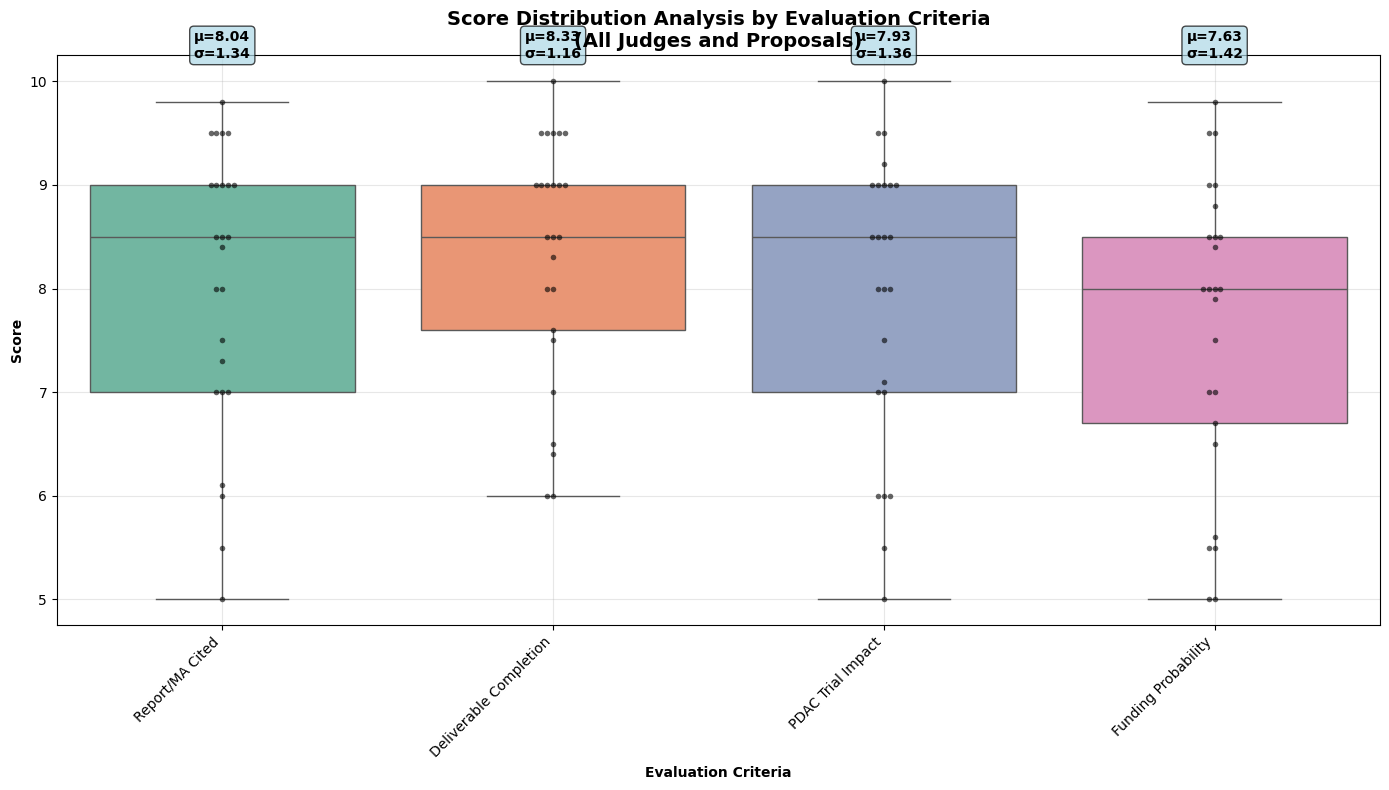

Distribution Analysis Summary:
--------------------------------------------------

Report/MA Cited:
  Mean: 8.04
  Std:  1.34
  Min:  5.00
  Max:  9.80

Deliverable Completion:
  Mean: 8.33
  Std:  1.16
  Min:  6.00
  Max:  10.00

PDAC Trial Impact:
  Mean: 7.93
  Std:  1.36
  Min:  5.00
  Max:  10.00

Funding Probability:
  Mean: 7.63
  Std:  1.42
  Min:  5.00
  Max:  9.80


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Organize data for box plots
criteria = ['Report/MA Cited', 'Deliverable Completion', 'PDAC Trial Impact', 'Funding Probability']

# All scores by criteria across all judges and proposals
criteria_data = {
    'Report/MA Cited': [9.5, 9.0, 8.5, 7.5, 6.0, 8.5, 9.5, 8.0, 7.0, 5.5,
                       9.5, 9.8, 9.0, 7.0, 5.0, 9.5, 9.0, 8.4, 7.3, 6.1,
                       9.0, 9.0, 8.5, 8.0, 7.0],
    'Deliverable Completion': [9.5, 9.0, 9.0, 8.0, 6.5, 9.5, 9.0, 8.5, 7.5, 6.0,
                              10.0, 9.5, 9.0, 8.5, 6.0, 9.5, 9.0, 8.3, 7.6, 6.4,
                              9.5, 9.0, 8.5, 8.0, 7.0],
    'PDAC Trial Impact': [9.0, 8.5, 9.5, 7.5, 6.0, 8.5, 9.5, 8.0, 7.0, 5.5,
                         9.0, 10.0, 8.5, 6.0, 5.0, 9.0, 9.2, 8.0, 7.1, 6.0,
                         9.0, 9.0, 8.5, 8.0, 7.0],
    'Funding Probability': [8.5, 9.0, 8.0, 7.0, 5.5, 8.0, 8.5, 7.5, 6.5, 5.0,
                           9.5, 9.8, 8.0, 5.5, 5.0, 8.8, 8.4, 7.9, 6.7, 5.6,
                           8.5, 9.5, 8.0, 9.0, 7.0]
}

# Create DataFrame for easier plotting
plot_data = []
for criterion, scores in criteria_data.items():
    for score in scores:
        plot_data.append({'Criterion': criterion, 'Score': score})

df = pd.DataFrame(plot_data)

# Create the box plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Criterion', y='Score', palette='Set2')
sns.swarmplot(data=df, x='Criterion', y='Score', color='black', alpha=0.6, size=4)

plt.title('Score Distribution Analysis by Evaluation Criteria\n(All Judges and Proposals)',
          fontsize=14, fontweight='bold')
plt.xlabel('Evaluation Criteria', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add statistical annotations
for i, criterion in enumerate(criteria):
    scores = criteria_data[criterion]
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    plt.text(i, 10.2, f'μ={mean_score:.2f}\nσ={std_score:.2f}',
             ha='center', va='bottom', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

# Print summary statistics
print("Distribution Analysis Summary:")
print("-" * 50)
for criterion, scores in criteria_data.items():
    print(f"\n{criterion}:")
    print(f"  Mean: {np.mean(scores):.2f}")
    print(f"  Std:  {np.std(scores):.2f}")
    print(f"  Min:  {np.min(scores):.2f}")
    print(f"  Max:  {np.max(scores):.2f}")

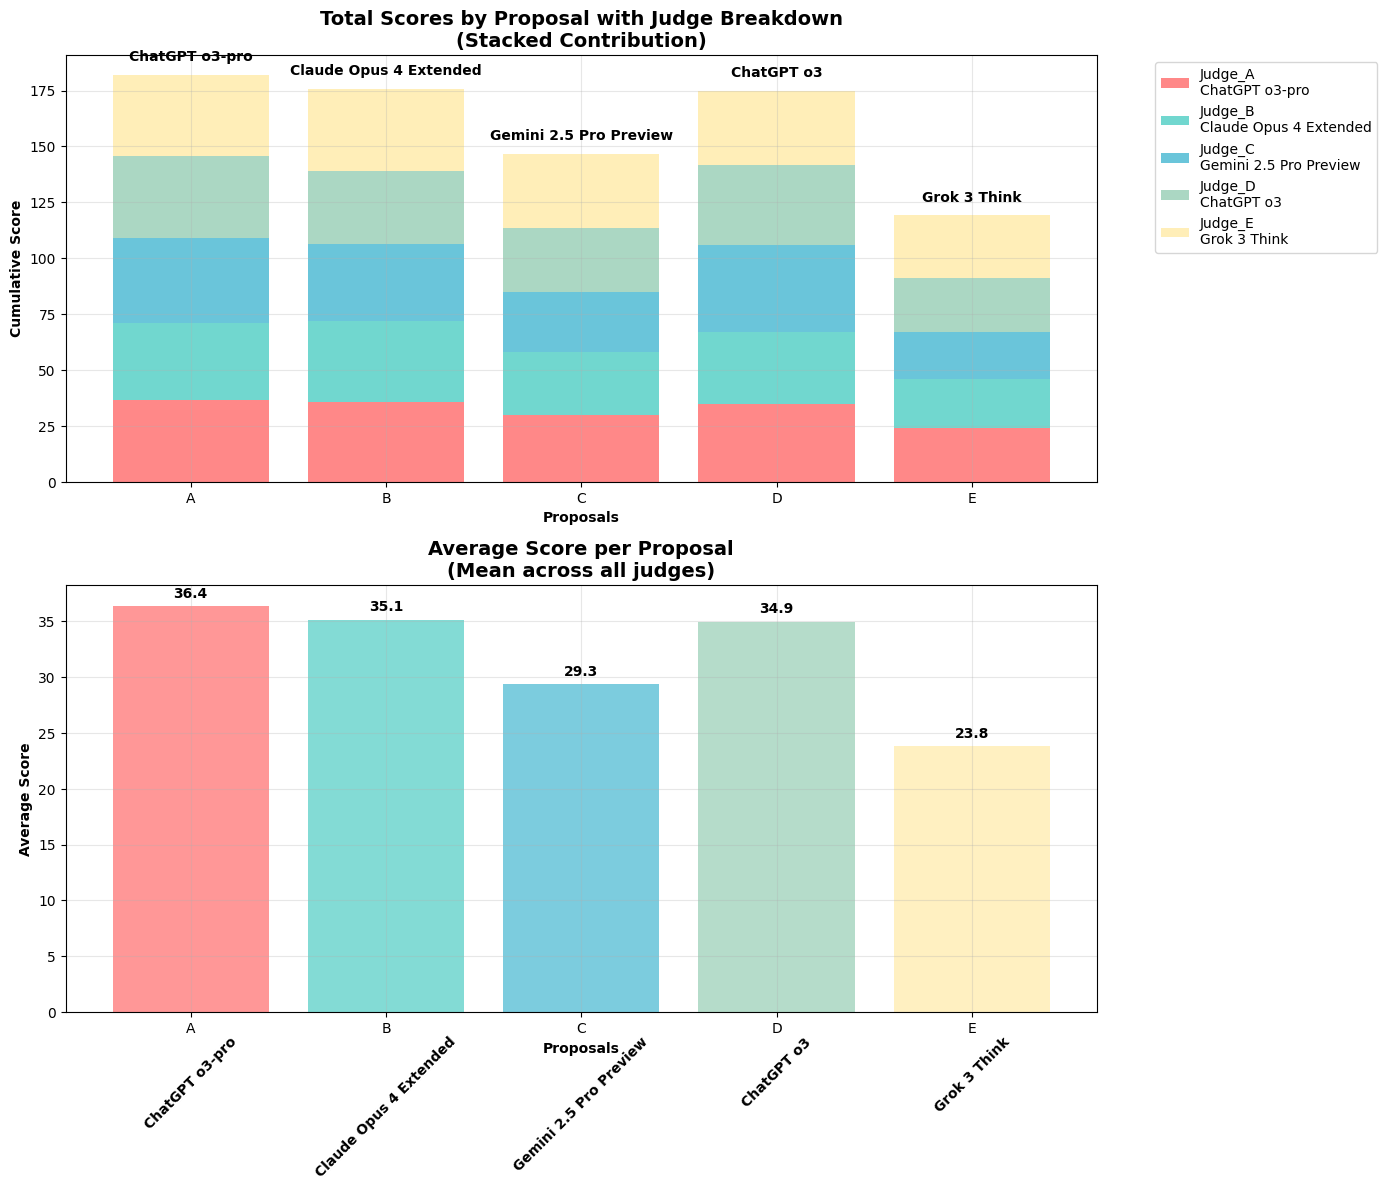

Final Rankings Summary:
------------------------------
1. Proposal A (ChatGPT o3-pro): 36.36
2. Proposal B (Claude Opus 4 Extended): 35.12
3. Proposal D (ChatGPT o3): 34.94
4. Proposal C (Gemini 2.5 Pro Preview): 29.34
5. Proposal E (Grok 3 Think): 23.82


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate total scores for each proposal by each judge
proposal_totals = {
    'A': {'Judge_A': 36.5, 'Judge_B': 34.5, 'Judge_C': 38.0, 'Judge_D': 36.8, 'Judge_E': 36.0},
    'B': {'Judge_A': 35.5, 'Judge_B': 36.5, 'Judge_C': 34.5, 'Judge_D': 32.6, 'Judge_E': 36.5},
    'C': {'Judge_A': 30.0, 'Judge_B': 28.0, 'Judge_C': 27.0, 'Judge_D': 28.7, 'Judge_E': 33.0},
    'D': {'Judge_A': 35.0, 'Judge_B': 32.0, 'Judge_C': 39.1, 'Judge_D': 35.6, 'Judge_E': 33.0},
    'E': {'Judge_A': 24.0, 'Judge_B': 22.0, 'Judge_C': 21.0, 'Judge_D': 24.1, 'Judge_E': 28.0}
}

# Prepare data for stacked bar chart
proposals = list(proposal_totals.keys())
judges = ['Judge_A', 'Judge_B', 'Judge_C', 'Judge_D', 'Judge_E']
judge_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Create arrays for stacking
judge_scores = np.array([[proposal_totals[prop][judge] for prop in proposals] for judge in judges])

# Create the stacked bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Stacked bar chart
bottom = np.zeros(len(proposals))
bars = []
for i, judge in enumerate(judges):
    bar = ax1.bar(proposals, judge_scores[i], bottom=bottom,
                  label=f'{judge}\n{model_names[judge[-1]]}',
                  color=judge_colors[i], alpha=0.8)
    bars.append(bar)
    bottom += judge_scores[i]

ax1.set_title('Total Scores by Proposal with Judge Breakdown\n(Stacked Contribution)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Proposals', fontweight='bold')
ax1.set_ylabel('Cumulative Score', fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Add proposal author labels
for i, prop in enumerate(proposals):
    ax1.text(i, bottom[i] + 5, f'{model_names[prop]}',
             ha='center', va='bottom', fontweight='bold', rotation=0)

# Average score comparison
avg_scores = [np.mean([proposal_totals[prop][judge] for judge in judges]) for prop in proposals]
colors_prop = [judge_colors[i] for i in range(len(proposals))]

bars2 = ax2.bar(proposals, avg_scores, color=colors_prop, alpha=0.7)
ax2.set_title('Average Score per Proposal\n(Mean across all judges)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Proposals', fontweight='bold')
ax2.set_ylabel('Average Score', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, (prop, score) in enumerate(zip(proposals, avg_scores)):
    ax2.text(i, score + 0.5, f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
    ax2.text(i, -2, f'{model_names[prop]}', ha='center', va='top',
             fontweight='bold', rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

# Print ranking summary
print("Final Rankings Summary:")
print("-" * 30)
sorted_proposals = sorted(proposals, key=lambda x: np.mean([proposal_totals[x][judge] for judge in judges]), reverse=True)
for i, prop in enumerate(sorted_proposals, 1):
    avg_score = np.mean([proposal_totals[prop][judge] for judge in judges])
    print(f"{i}. Proposal {prop} ({model_names[prop]}): {avg_score:.2f}")

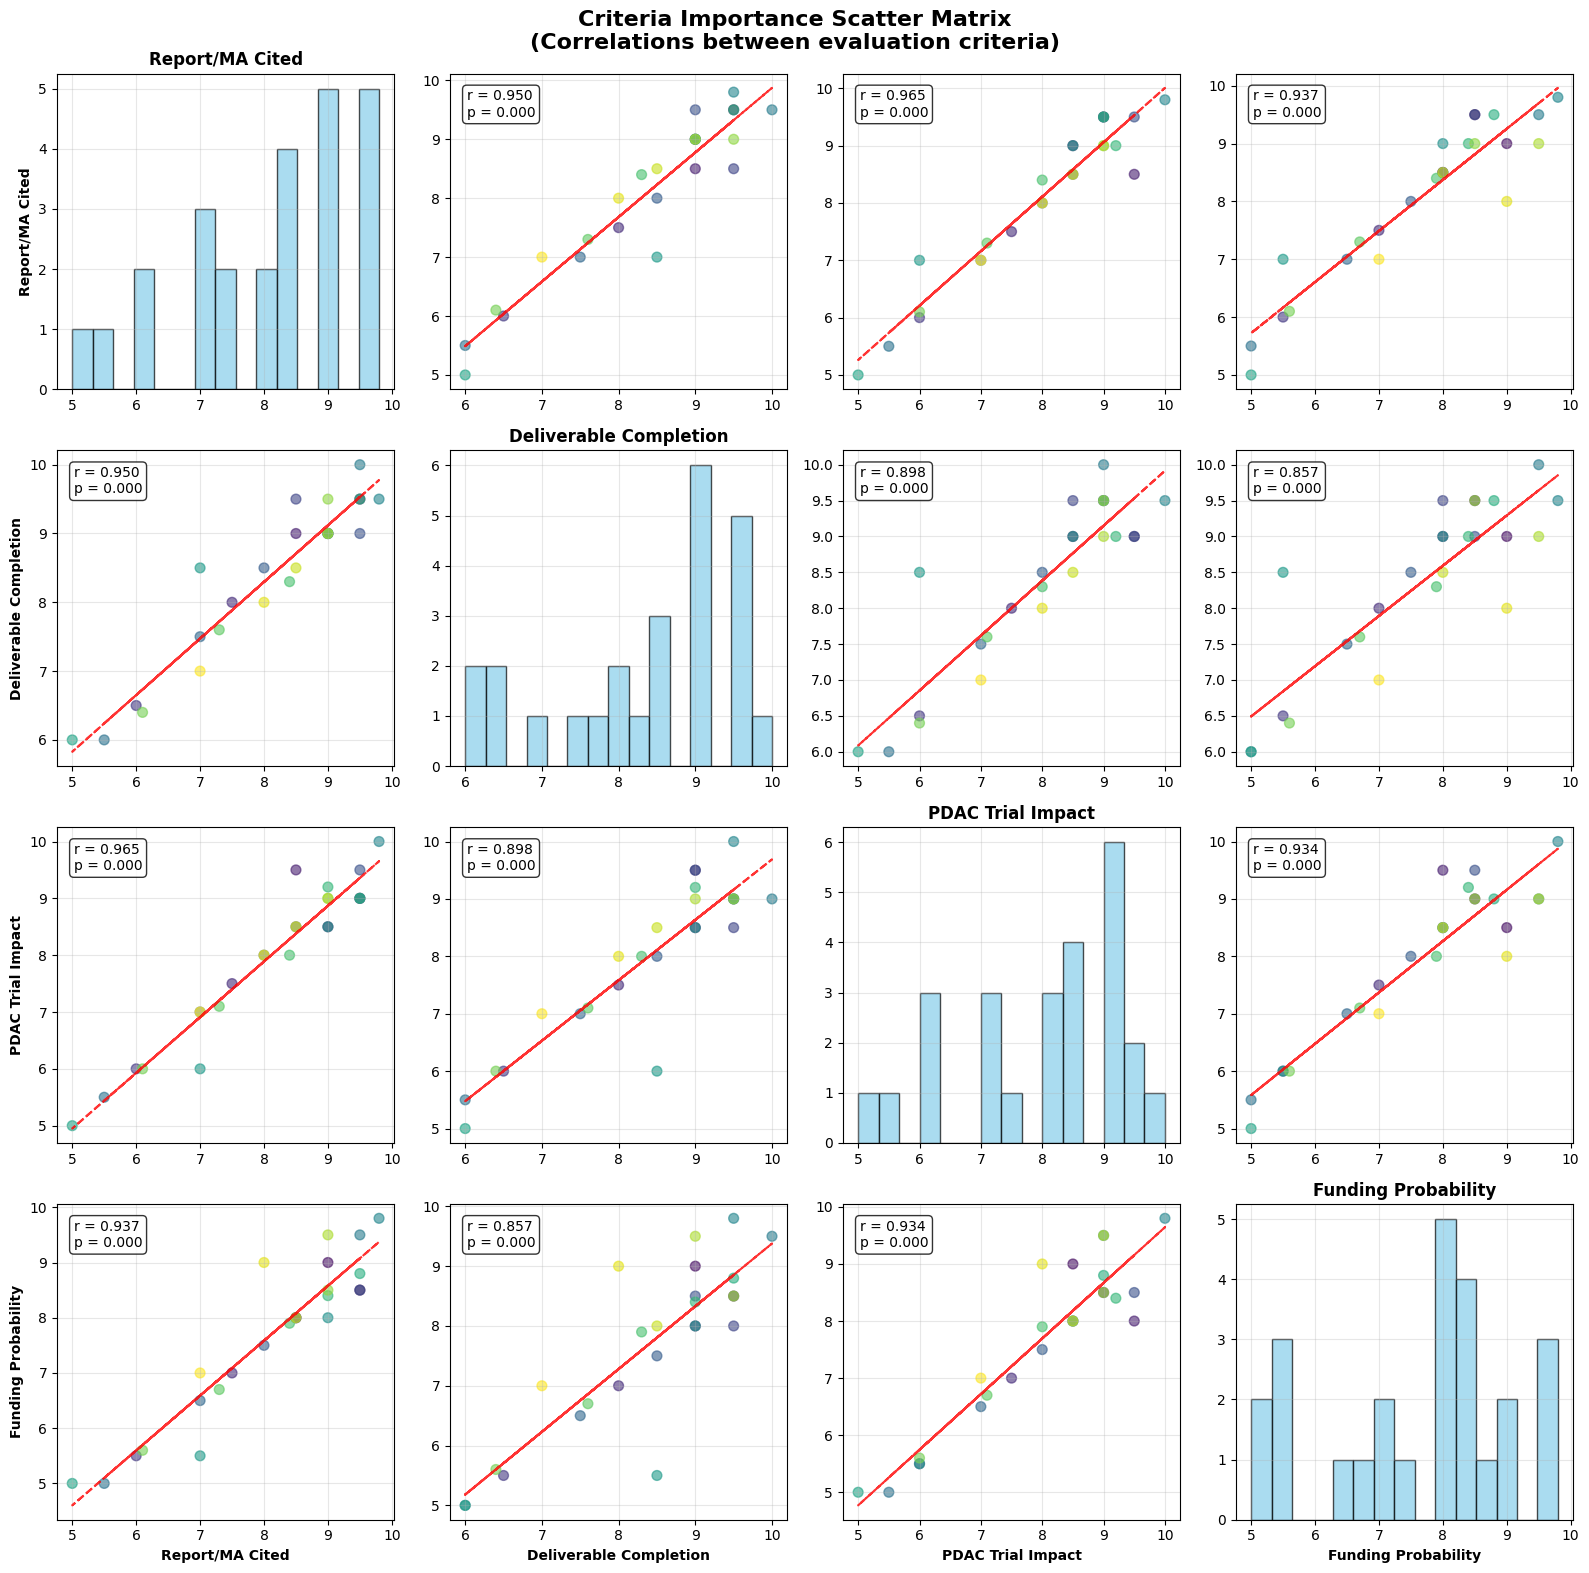

Criteria Correlation Matrix:
--------------------------------------------------
                        Report/MA_Cited  Deliverable_Completion  \
Report/MA_Cited                   1.000                   0.950   
Deliverable_Completion            0.950                   1.000   
PDAC_Trial_Impact                 0.965                   0.898   
Funding_Probability               0.937                   0.857   

                        PDAC_Trial_Impact  Funding_Probability  
Report/MA_Cited                     0.965                0.937  
Deliverable_Completion              0.898                0.857  
PDAC_Trial_Impact                   1.000                0.934  
Funding_Probability                 0.934                1.000  

Strongest Correlations:
-------------------------
Report/MA_Cited vs Deliverable_Completion: 0.950
Report/MA_Cited vs PDAC_Trial_Impact: 0.965
Report/MA_Cited vs Funding_Probability: 0.937
Deliverable_Completion vs PDAC_Trial_Impact: 0.898
Deliverable_Comple

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Organize all scores by criteria
all_scores = {
    'Report/MA_Cited': [9.5, 9.0, 8.5, 7.5, 6.0, 8.5, 9.5, 8.0, 7.0, 5.5,
                       9.5, 9.8, 9.0, 7.0, 5.0, 9.5, 9.0, 8.4, 7.3, 6.1,
                       9.0, 9.0, 8.5, 8.0, 7.0],
    'Deliverable_Completion': [9.5, 9.0, 9.0, 8.0, 6.5, 9.5, 9.0, 8.5, 7.5, 6.0,
                              10.0, 9.5, 9.0, 8.5, 6.0, 9.5, 9.0, 8.3, 7.6, 6.4,
                              9.5, 9.0, 8.5, 8.0, 7.0],
    'PDAC_Trial_Impact': [9.0, 8.5, 9.5, 7.5, 6.0, 8.5, 9.5, 8.0, 7.0, 5.5,
                         9.0, 10.0, 8.5, 6.0, 5.0, 9.0, 9.2, 8.0, 7.1, 6.0,
                         9.0, 9.0, 8.5, 8.0, 7.0],
    'Funding_Probability': [8.5, 9.0, 8.0, 7.0, 5.5, 8.0, 8.5, 7.5, 6.5, 5.0,
                           9.5, 9.8, 8.0, 5.5, 5.0, 8.8, 8.4, 7.9, 6.7, 5.6,
                           8.5, 9.5, 8.0, 9.0, 7.0]
}

# Create DataFrame
df = pd.DataFrame(all_scores)

# Create scatter matrix
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

criteria_names = list(all_scores.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

for i in range(4):
    for j in range(4):
        ax = axes[i, j]

        if i == j:
            # Diagonal: histogram
            ax.hist(df.iloc[:, i], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            ax.set_title(f'{criteria_names[i].replace("_", " ")}', fontweight='bold')
        else:
            # Off-diagonal: scatter plot
            ax.scatter(df.iloc[:, j], df.iloc[:, i], alpha=0.6, c=colors, s=50)

            # Add correlation coefficient
            corr, p_val = pearsonr(df.iloc[:, j], df.iloc[:, i])
            ax.text(0.05, 0.95, f'r = {corr:.3f}\np = {p_val:.3f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Add trend line
            z = np.polyfit(df.iloc[:, j], df.iloc[:, i], 1)
            p = np.poly1d(z)
            ax.plot(df.iloc[:, j], p(df.iloc[:, j]), "r--", alpha=0.8)

        if i == 3:  # Bottom row
            ax.set_xlabel(criteria_names[j].replace("_", " "), fontweight='bold')
        if j == 0:  # Left column
            ax.set_ylabel(criteria_names[i].replace("_", " "), fontweight='bold')

        ax.grid(True, alpha=0.3)

plt.suptitle('Criteria Importance Scatter Matrix\n(Correlations between evaluation criteria)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate and print correlation matrix
corr_matrix = df.corr()
print("Criteria Correlation Matrix:")
print("-" * 50)
print(corr_matrix.round(3))

# Find strongest correlations
print("\nStrongest Correlations:")
print("-" * 25)
for i in range(len(criteria_names)):
    for j in range(i+1, len(criteria_names)):
        corr_val = corr_matrix.iloc[i, j]
        print(f"{criteria_names[i]} vs {criteria_names[j]}: {corr_val:.3f}")

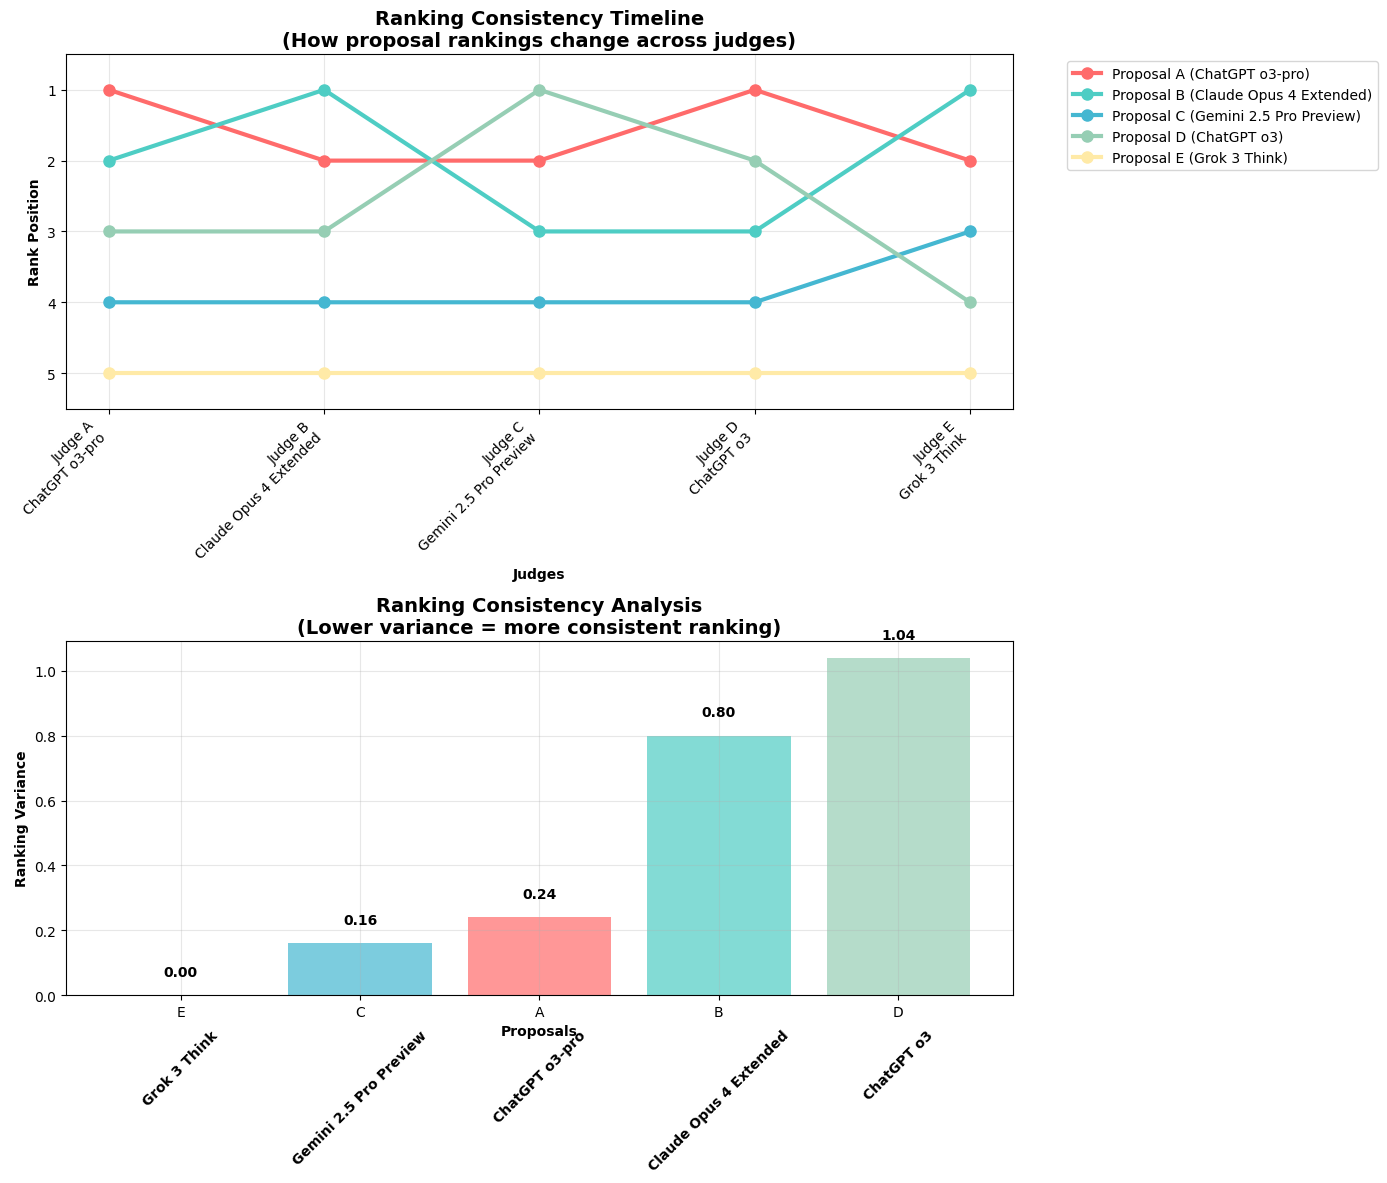

Ranking Consistency Analysis:
----------------------------------------
Most Consistent Rankings (lowest variance):
1. Proposal E (Grok 3 Think): Variance = 0.00
2. Proposal C (Gemini 2.5 Pro Preview): Variance = 0.16
3. Proposal A (ChatGPT o3-pro): Variance = 0.24
4. Proposal B (Claude Opus 4 Extended): Variance = 0.80
5. Proposal D (ChatGPT o3): Variance = 1.04

Average ranking variance: 0.45


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate rankings for each judge
judge_rankings = {}

# Judge A rankings (based on total scores)
judge_rankings['A'] = {'A': 1, 'B': 2, 'D': 3, 'C': 4, 'E': 5}

# Judge B rankings
judge_rankings['B'] = {'B': 1, 'A': 2, 'D': 3, 'C': 4, 'E': 5}

# Judge C rankings (explicitly provided)
judge_rankings['C'] = {'D': 1, 'A': 2, 'B': 3, 'C': 4, 'E': 5}

# Judge D rankings
judge_rankings['D'] = {'A': 1, 'D': 2, 'B': 3, 'C': 4, 'E': 5}

# Judge E rankings (based on scores)
judge_rankings['E'] = {'B': 1, 'A': 2, 'C': 3, 'D': 4, 'E': 5}

# Create timeline data
judges_order = ['A', 'B', 'C', 'D', 'E']
proposals = ['A', 'B', 'C', 'D', 'E']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Prepare data for plotting
timeline_data = {}
for prop in proposals:
    timeline_data[prop] = [judge_rankings[judge][prop] for judge in judges_order]

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Line plot for ranking changes
for i, prop in enumerate(proposals):
    ax1.plot(judges_order, timeline_data[prop], 'o-', linewidth=3,
             markersize=8, label=f'Proposal {prop} ({model_names[prop]})',
             color=colors[i])

ax1.set_title('Ranking Consistency Timeline\n(How proposal rankings change across judges)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Judges', fontweight='bold')
ax1.set_ylabel('Rank Position', fontweight='bold')
ax1.set_ylim(5.5, 0.5)  # Invert y-axis so rank 1 is at top
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add judge model names
judge_labels = [f'Judge {j}\n{model_names[j]}' for j in judges_order]
ax1.set_xticks(range(len(judges_order)))
ax1.set_xticklabels(judge_labels, rotation=45, ha='right')

# Ranking variance analysis
ranking_variance = {}
for prop in proposals:
    rankings = timeline_data[prop]
    ranking_variance[prop] = np.var(rankings)

# Bar chart for ranking consistency
props_sorted = sorted(proposals, key=lambda x: ranking_variance[x])
variances = [ranking_variance[prop] for prop in props_sorted]
bars = ax2.bar(props_sorted, variances, color=[colors[proposals.index(p)] for p in props_sorted], alpha=0.7)

ax2.set_title('Ranking Consistency Analysis\n(Lower variance = more consistent ranking)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Proposals', fontweight='bold')
ax2.set_ylabel('Ranking Variance', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels and model names
for i, (prop, var) in enumerate(zip(props_sorted, variances)):
    ax2.text(i, var + 0.05, f'{var:.2f}', ha='center', va='bottom', fontweight='bold')
    ax2.text(i, -0.1, f'{model_names[prop]}', ha='center', va='top',
             fontweight='bold', rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

# Print consistency analysis
print("Ranking Consistency Analysis:")
print("-" * 40)
print("Most Consistent Rankings (lowest variance):")
for i, prop in enumerate(props_sorted):
    consistency_score = 1 / (1 + ranking_variance[prop])  # Higher score = more consistent
    print(f"{i+1}. Proposal {prop} ({model_names[prop]}): Variance = {ranking_variance[prop]:.2f}")

print(f"\nAverage ranking variance: {np.mean(list(ranking_variance.values())):.2f}")

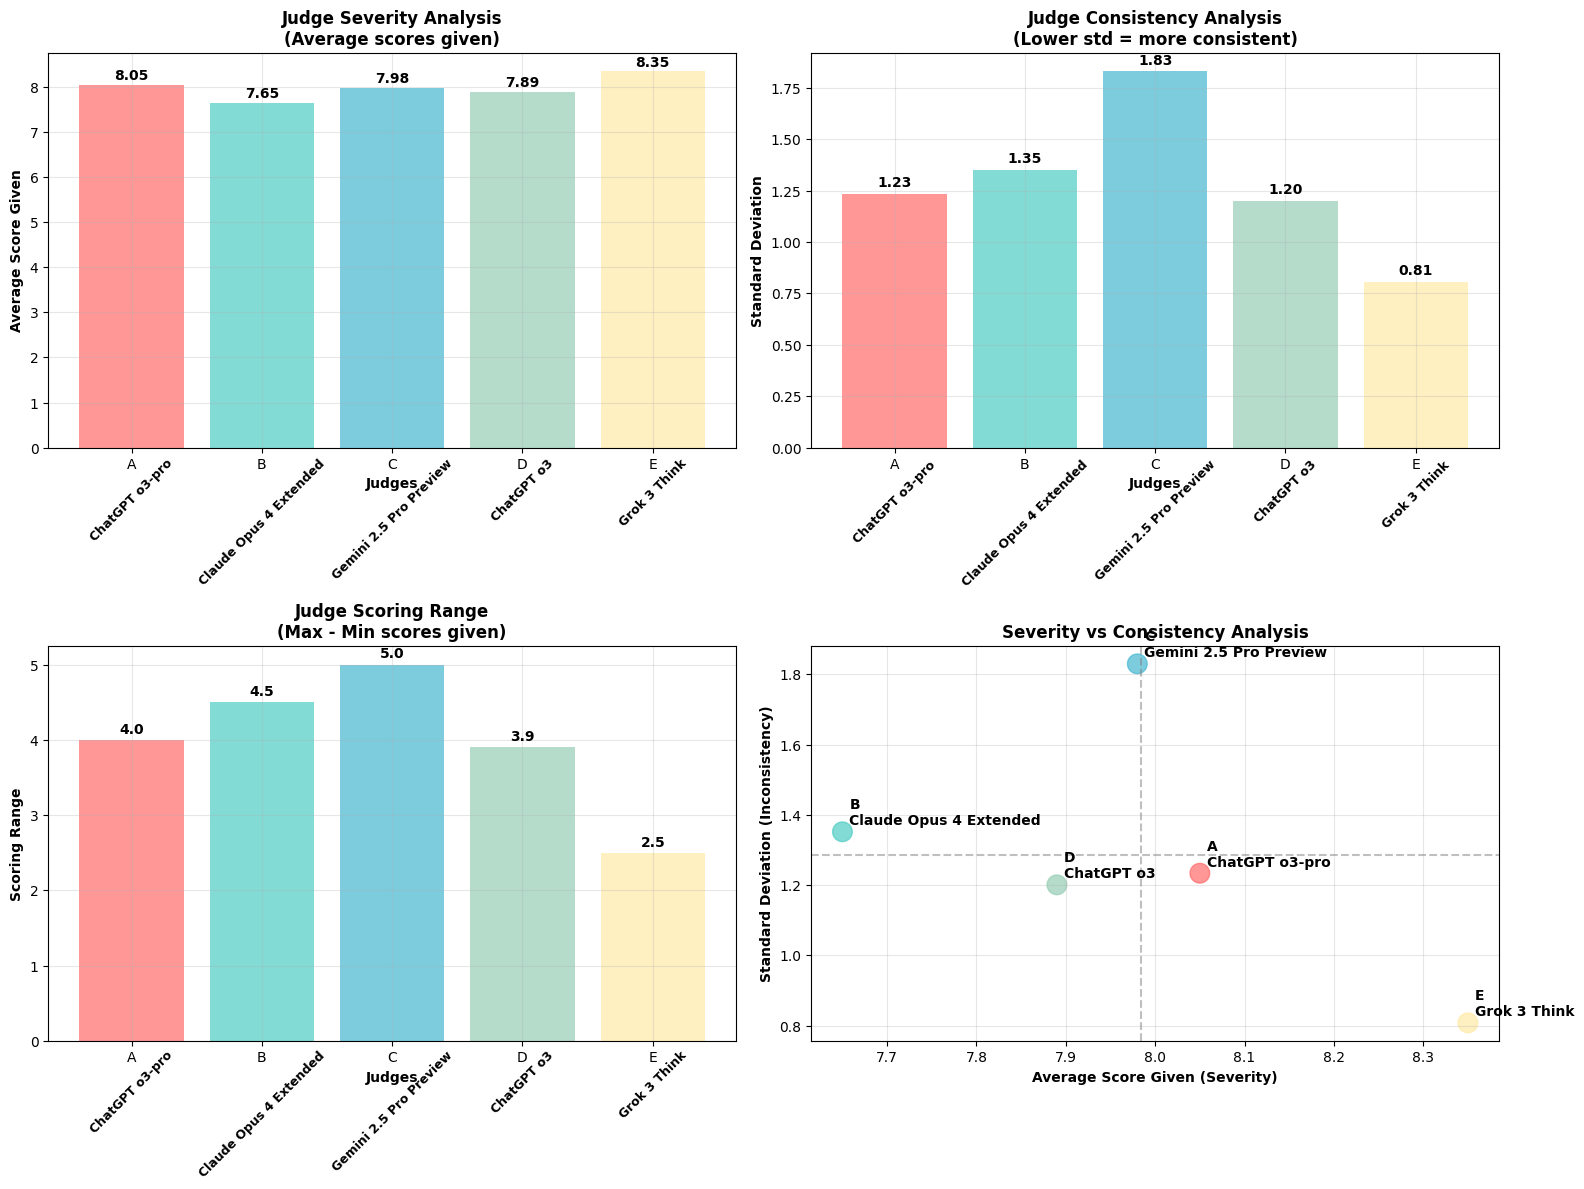

Judge Severity Analysis Summary:
--------------------------------------------------
Ranking by Average Score (Most Lenient to Most Strict):
1. Judge E (Grok 3 Think): 8.35
2. Judge A (ChatGPT o3-pro): 8.05
3. Judge C (Gemini 2.5 Pro Preview): 7.98
4. Judge D (ChatGPT o3): 7.89
5. Judge B (Claude Opus 4 Extended): 7.65

Ranking by Consistency (Most Consistent to Least):
1. Judge E (Grok 3 Think): σ = 0.81
2. Judge D (ChatGPT o3): σ = 1.20
3. Judge A (ChatGPT o3-pro): σ = 1.23
4. Judge B (Claude Opus 4 Extended): σ = 1.35
5. Judge C (Gemini 2.5 Pro Preview): σ = 1.83


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Calculate average scores given by each judge
judge_averages = {
    'A': np.mean([9.5, 9.5, 9.0, 8.5, 9.0, 9.0, 8.5, 9.0, 8.5, 9.0, 9.5, 8.0, 7.5, 8.0, 7.5, 7.0, 6.0, 6.5, 6.0, 5.5]),
    'B': np.mean([8.5, 9.5, 8.5, 8.0, 9.5, 9.0, 9.5, 8.5, 8.0, 8.5, 8.0, 7.5, 7.0, 7.5, 7.0, 6.5, 5.5, 6.0, 5.5, 5.0]),
    'C': np.mean([9.5, 10.0, 9.0, 9.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 8.5, 8.0, 7.0, 8.5, 6.0, 5.5, 5.0, 6.0, 5.0, 5.0]),
    'D': np.mean([9.5, 9.5, 9.0, 8.8, 9.0, 9.0, 9.2, 8.4, 8.4, 8.3, 8.0, 7.9, 7.3, 7.6, 7.1, 6.7, 6.1, 6.4, 6.0, 5.6]),
    'E': np.mean([9.0, 9.5, 9.0, 8.5, 9.0, 9.0, 9.0, 9.5, 8.5, 8.5, 8.5, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 7.0, 7.0, 7.0])
}

# Calculate standard deviations (measure of scoring spread)
judge_stds = {
    'A': np.std([9.5, 9.5, 9.0, 8.5, 9.0, 9.0, 8.5, 9.0, 8.5, 9.0, 9.5, 8.0, 7.5, 8.0, 7.5, 7.0, 6.0, 6.5, 6.0, 5.5]),
    'B': np.std([8.5, 9.5, 8.5, 8.0, 9.5, 9.0, 9.5, 8.5, 8.0, 8.5, 8.0, 7.5, 7.0, 7.5, 7.0, 6.5, 5.5, 6.0, 5.5, 5.0]),
    'C': np.std([9.5, 10.0, 9.0, 9.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 8.5, 8.0, 7.0, 8.5, 6.0, 5.5, 5.0, 6.0, 5.0, 5.0]),
    'D': np.std([9.5, 9.5, 9.0, 8.8, 9.0, 9.0, 9.2, 8.4, 8.4, 8.3, 8.0, 7.9, 7.3, 7.6, 7.1, 6.7, 6.1, 6.4, 6.0, 5.6]),
    'E': np.std([9.0, 9.5, 9.0, 8.5, 9.0, 9.0, 9.0, 9.5, 8.5, 8.5, 8.5, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 7.0, 7.0, 7.0])
}

# Calculate scoring ranges (max - min)
judge_ranges = {
    'A': max([9.5, 9.5, 9.0, 8.5, 9.0, 9.0, 8.5, 9.0, 8.5, 9.0, 9.5, 8.0, 7.5, 8.0, 7.5, 7.0, 6.0, 6.5, 6.0, 5.5]) -
         min([9.5, 9.5, 9.0, 8.5, 9.0, 9.0, 8.5, 9.0, 8.5, 9.0, 9.5, 8.0, 7.5, 8.0, 7.5, 7.0, 6.0, 6.5, 6.0, 5.5]),
    'B': max([8.5, 9.5, 8.5, 8.0, 9.5, 9.0, 9.5, 8.5, 8.0, 8.5, 8.0, 7.5, 7.0, 7.5, 7.0, 6.5, 5.5, 6.0, 5.5, 5.0]) -
         min([8.5, 9.5, 8.5, 8.0, 9.5, 9.0, 9.5, 8.5, 8.0, 8.5, 8.0, 7.5, 7.0, 7.5, 7.0, 6.5, 5.5, 6.0, 5.5, 5.0]),
    'C': max([9.5, 10.0, 9.0, 9.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 8.5, 8.0, 7.0, 8.5, 6.0, 5.5, 5.0, 6.0, 5.0, 5.0]) -
         min([9.5, 10.0, 9.0, 9.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 8.5, 8.0, 7.0, 8.5, 6.0, 5.5, 5.0, 6.0, 5.0, 5.0]),
    'D': max([9.5, 9.5, 9.0, 8.8, 9.0, 9.0, 9.2, 8.4, 8.4, 8.3, 8.0, 7.9, 7.3, 7.6, 7.1, 6.7, 6.1, 6.4, 6.0, 5.6]) -
         min([9.5, 9.5, 9.0, 8.8, 9.0, 9.0, 9.2, 8.4, 8.4, 8.3, 8.0, 7.9, 7.3, 7.6, 7.1, 6.7, 6.1, 6.4, 6.0, 5.6]),
    'E': max([9.0, 9.5, 9.0, 8.5, 9.0, 9.0, 9.0, 9.5, 8.5, 8.5, 8.5, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 7.0, 7.0, 7.0]) -
         min([9.0, 9.5, 9.0, 8.5, 9.0, 9.0, 9.0, 9.5, 8.5, 8.5, 8.5, 8.0, 8.0, 8.0, 8.0, 9.0, 7.0, 7.0, 7.0, 7.0])
}

# Create the analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

judges = list(judge_averages.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# 1. Average scores by judge (severity)
avgs = [judge_averages[j] for j in judges]
bars1 = ax1.bar(judges, avgs, color=colors, alpha=0.7)
ax1.set_title('Judge Severity Analysis\n(Average scores given)', fontweight='bold')
ax1.set_ylabel('Average Score Given', fontweight='bold')
ax1.set_xlabel('Judges', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add value labels and model names
for i, (judge, avg) in enumerate(zip(judges, avgs)):
    ax1.text(i, avg + 0.05, f'{avg:.2f}', ha='center', va='bottom', fontweight='bold')
    ax1.text(i, -0.2, f'{model_names[judge]}', ha='center', va='top',
             fontweight='bold', rotation=45, fontsize=9)

# 2. Standard deviation (consistency)
stds = [judge_stds[j] for j in judges]
bars2 = ax2.bar(judges, stds, color=colors, alpha=0.7)
ax2.set_title('Judge Consistency Analysis\n(Lower std = more consistent)', fontweight='bold')
ax2.set_ylabel('Standard Deviation', fontweight='bold')
ax2.set_xlabel('Judges', fontweight='bold')
ax2.grid(True, alpha=0.3)

for i, (judge, std) in enumerate(zip(judges, stds)):
    ax2.text(i, std + 0.02, f'{std:.2f}', ha='center', va='bottom', fontweight='bold')
    ax2.text(i, -0.05, f'{model_names[judge]}', ha='center', va='top',
             fontweight='bold', rotation=45, fontsize=9)

# 3. Scoring range
ranges = [judge_ranges[j] for j in judges]
bars3 = ax3.bar(judges, ranges, color=colors, alpha=0.7)
ax3.set_title('Judge Scoring Range\n(Max - Min scores given)', fontweight='bold')
ax3.set_ylabel('Scoring Range', fontweight='bold')
ax3.set_xlabel('Judges', fontweight='bold')
ax3.grid(True, alpha=0.3)

for i, (judge, rng) in enumerate(zip(judges, ranges)):
    ax3.text(i, rng + 0.05, f'{rng:.1f}', ha='center', va='bottom', fontweight='bold')
    ax3.text(i, -0.1, f'{model_names[judge]}', ha='center', va='top',
             fontweight='bold', rotation=45, fontsize=9)

# 4. Severity vs Consistency scatter plot
ax4.scatter(avgs, stds, c=colors, s=200, alpha=0.7)
for i, judge in enumerate(judges):
    ax4.annotate(f'{judge}\n{model_names[judge]}', (avgs[i], stds[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

ax4.set_xlabel('Average Score Given (Severity)', fontweight='bold')
ax4.set_ylabel('Standard Deviation (Inconsistency)', fontweight='bold')
ax4.set_title('Severity vs Consistency Analysis', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add quadrant labels
ax4.axhline(y=np.mean(stds), color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=np.mean(avgs), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary
print("Judge Severity Analysis Summary:")
print("-" * 50)
print("Ranking by Average Score (Most Lenient to Most Strict):")
judges_by_avg = sorted(judges, key=lambda x: judge_averages[x], reverse=True)
for i, judge in enumerate(judges_by_avg, 1):
    print(f"{i}. Judge {judge} ({model_names[judge]}): {judge_averages[judge]:.2f}")

print(f"\nRanking by Consistency (Most Consistent to Least):")
judges_by_std = sorted(judges, key=lambda x: judge_stds[x])
for i, judge in enumerate(judges_by_std, 1):
    print(f"{i}. Judge {judge} ({model_names[judge]}): σ = {judge_stds[judge]:.2f}")

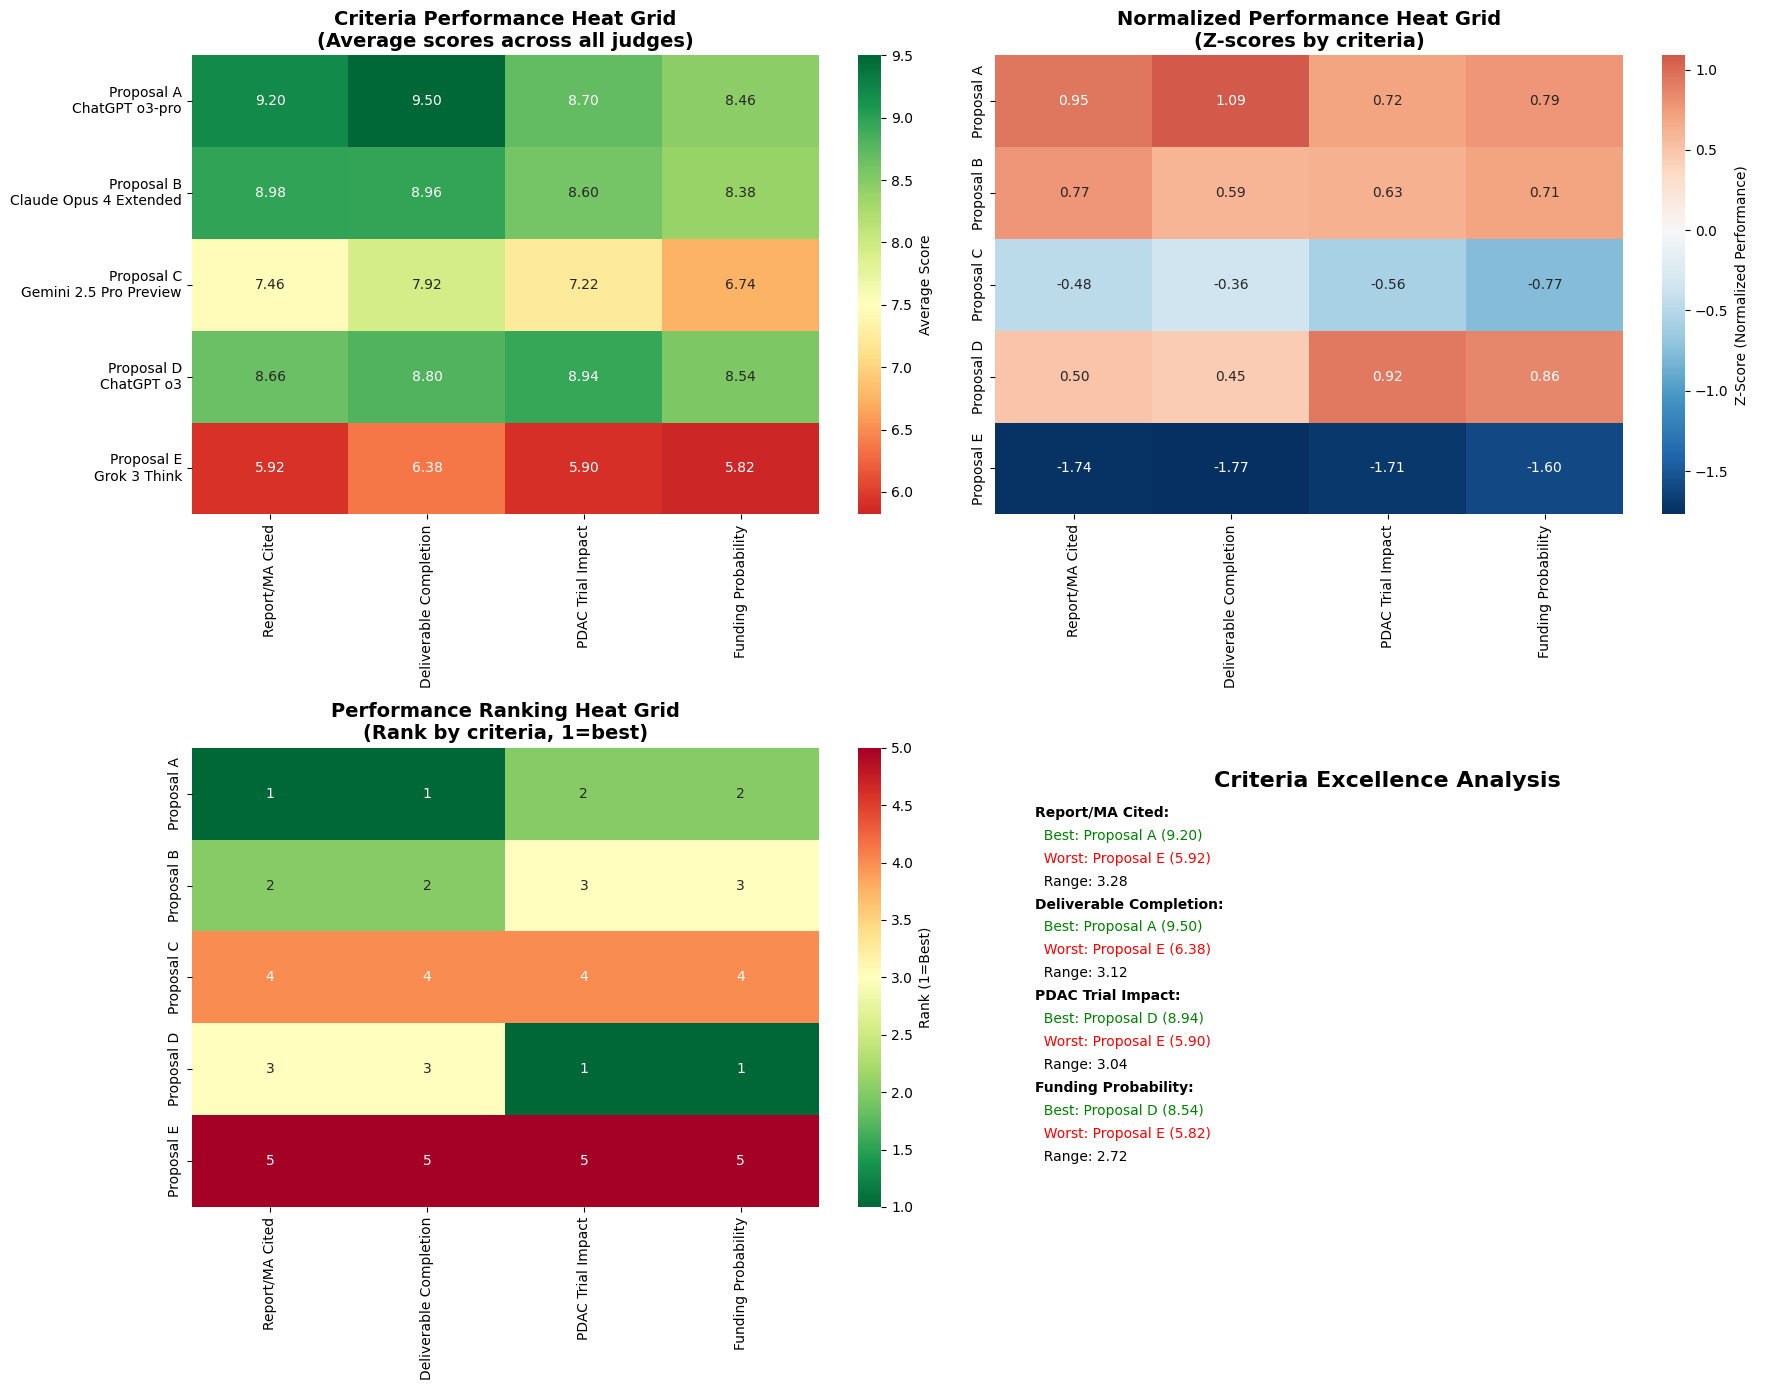

Criteria Performance Analysis:
--------------------------------------------------
Criteria Difficulty (lower average = more difficult):
Report/MA Cited: μ=8.04, σ=1.22
Deliverable Completion: μ=8.31, σ=1.09
PDAC Trial Impact: μ=7.87, σ=1.15
Funding Probability: μ=7.59, σ=1.11

Top Performers by Criteria:
------------------------------

Report/MA Cited:
  1. Proposal A (ChatGPT o3-pro): 9.20
  2. Proposal B (Claude Opus 4 Extended): 8.98
  3. Proposal D (ChatGPT o3): 8.66
  4. Proposal C (Gemini 2.5 Pro Preview): 7.46
  5. Proposal E (Grok 3 Think): 5.92

Deliverable Completion:
  1. Proposal A (ChatGPT o3-pro): 9.50
  2. Proposal B (Claude Opus 4 Extended): 8.96
  3. Proposal D (ChatGPT o3): 8.80
  4. Proposal C (Gemini 2.5 Pro Preview): 7.92
  5. Proposal E (Grok 3 Think): 6.38

PDAC Trial Impact:
  1. Proposal D (ChatGPT o3): 8.94
  2. Proposal A (ChatGPT o3-pro): 8.70
  3. Proposal B (Claude Opus 4 Extended): 8.60
  4. Proposal C (Gemini 2.5 Pro Preview): 7.22
  5. Proposal E (Grok 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Organize average scores by proposal and criteria
criteria = ['Report/MA Cited', 'Deliverable Completion', 'PDAC Trial Impact', 'Funding Probability']
proposals = ['A', 'B', 'C', 'D', 'E']

# Calculate average scores across all judges for each proposal-criteria combination
performance_matrix = np.array([
    [9.2, 9.5, 8.7, 8.46],  # Proposal A
    [8.98, 8.96, 8.6, 8.38],  # Proposal B
    [7.46, 7.92, 7.22, 6.74],  # Proposal C
    [8.66, 8.8, 8.94, 8.54],   # Proposal D
    [5.92, 6.38, 5.9, 5.82]    # Proposal E
])

# Create the main heatmap
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Main performance heatmap
sns.heatmap(performance_matrix,
            xticklabels=criteria,
            yticklabels=[f"Proposal {p}\n{model_names[p]}" for p in proposals],
            annot=True, fmt='.2f', cmap='RdYlGn', center=7.5,
            cbar_kws={'label': 'Average Score'}, ax=ax1)
ax1.set_title('Criteria Performance Heat Grid\n(Average scores across all judges)',
              fontsize=14, fontweight='bold')

# 2. Normalized performance (z-scores by criteria)
normalized_matrix = (performance_matrix - performance_matrix.mean(axis=0)) / performance_matrix.std(axis=0)
sns.heatmap(normalized_matrix,
            xticklabels=criteria,
            yticklabels=[f"Proposal {p}" for p in proposals],
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Z-Score (Normalized Performance)'}, ax=ax2)
ax2.set_title('Normalized Performance Heat Grid\n(Z-scores by criteria)',
              fontsize=14, fontweight='bold')

# 3. Performance ranking matrix
ranking_matrix = np.zeros_like(performance_matrix)
for j in range(performance_matrix.shape[1]):  # For each criteria
    sorted_indices = np.argsort(performance_matrix[:, j])[::-1]  # Descending order
    for rank, idx in enumerate(sorted_indices):
        ranking_matrix[idx, j] = rank + 1

sns.heatmap(ranking_matrix,
            xticklabels=criteria,
            yticklabels=[f"Proposal {p}" for p in proposals],
            annot=True, fmt='.0f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Rank (1=Best)'}, ax=ax3)
ax3.set_title('Performance Ranking Heat Grid\n(Rank by criteria, 1=best)',
              fontsize=14, fontweight='bold')

# 4. Criteria strength analysis
criteria_means = performance_matrix.mean(axis=0)
criteria_stds = performance_matrix.std(axis=0)
proposal_names = [f"Proposal {p}" for p in proposals]

# Show which proposal excels in each criteria
ax4.axis('off')
ax4.text(0.5, 0.95, 'Criteria Excellence Analysis',
         ha='center', va='top', fontsize=16, fontweight='bold', transform=ax4.transAxes)

y_pos = 0.85
for i, criterion in enumerate(criteria):
    best_proposal_idx = np.argmax(performance_matrix[:, i])
    best_score = performance_matrix[best_proposal_idx, i]
    worst_proposal_idx = np.argmin(performance_matrix[:, i])
    worst_score = performance_matrix[worst_proposal_idx, i]

    ax4.text(0.05, y_pos, f'{criterion}:', fontweight='bold', transform=ax4.transAxes)
    ax4.text(0.05, y_pos-0.05, f'  Best: Proposal {proposals[best_proposal_idx]} ({best_score:.2f})',
             color='green', transform=ax4.transAxes)
    ax4.text(0.05, y_pos-0.1, f'  Worst: Proposal {proposals[worst_proposal_idx]} ({worst_score:.2f})',
             color='red', transform=ax4.transAxes)
    ax4.text(0.05, y_pos-0.15, f'  Range: {best_score - worst_score:.2f}',
             transform=ax4.transAxes)
    y_pos -= 0.2

plt.tight_layout()
plt.show()

# Additional analysis: Create criteria difficulty analysis
print("Criteria Performance Analysis:")
print("-" * 50)
print("Criteria Difficulty (lower average = more difficult):")
for i, criterion in enumerate(criteria):
    mean_score = criteria_means[i]
    std_score = criteria_stds[i]
    print(f"{criterion}: μ={mean_score:.2f}, σ={std_score:.2f}")

print("\nTop Performers by Criteria:")
print("-" * 30)
for i, criterion in enumerate(criteria):
    sorted_proposals = sorted(range(len(proposals)),
                            key=lambda x: performance_matrix[x, i], reverse=True)
    print(f"\n{criterion}:")
    for rank, prop_idx in enumerate(sorted_proposals, 1):
        score = performance_matrix[prop_idx, i]
        print(f"  {rank}. Proposal {proposals[prop_idx]} ({model_names[proposals[prop_idx]]}): {score:.2f}")

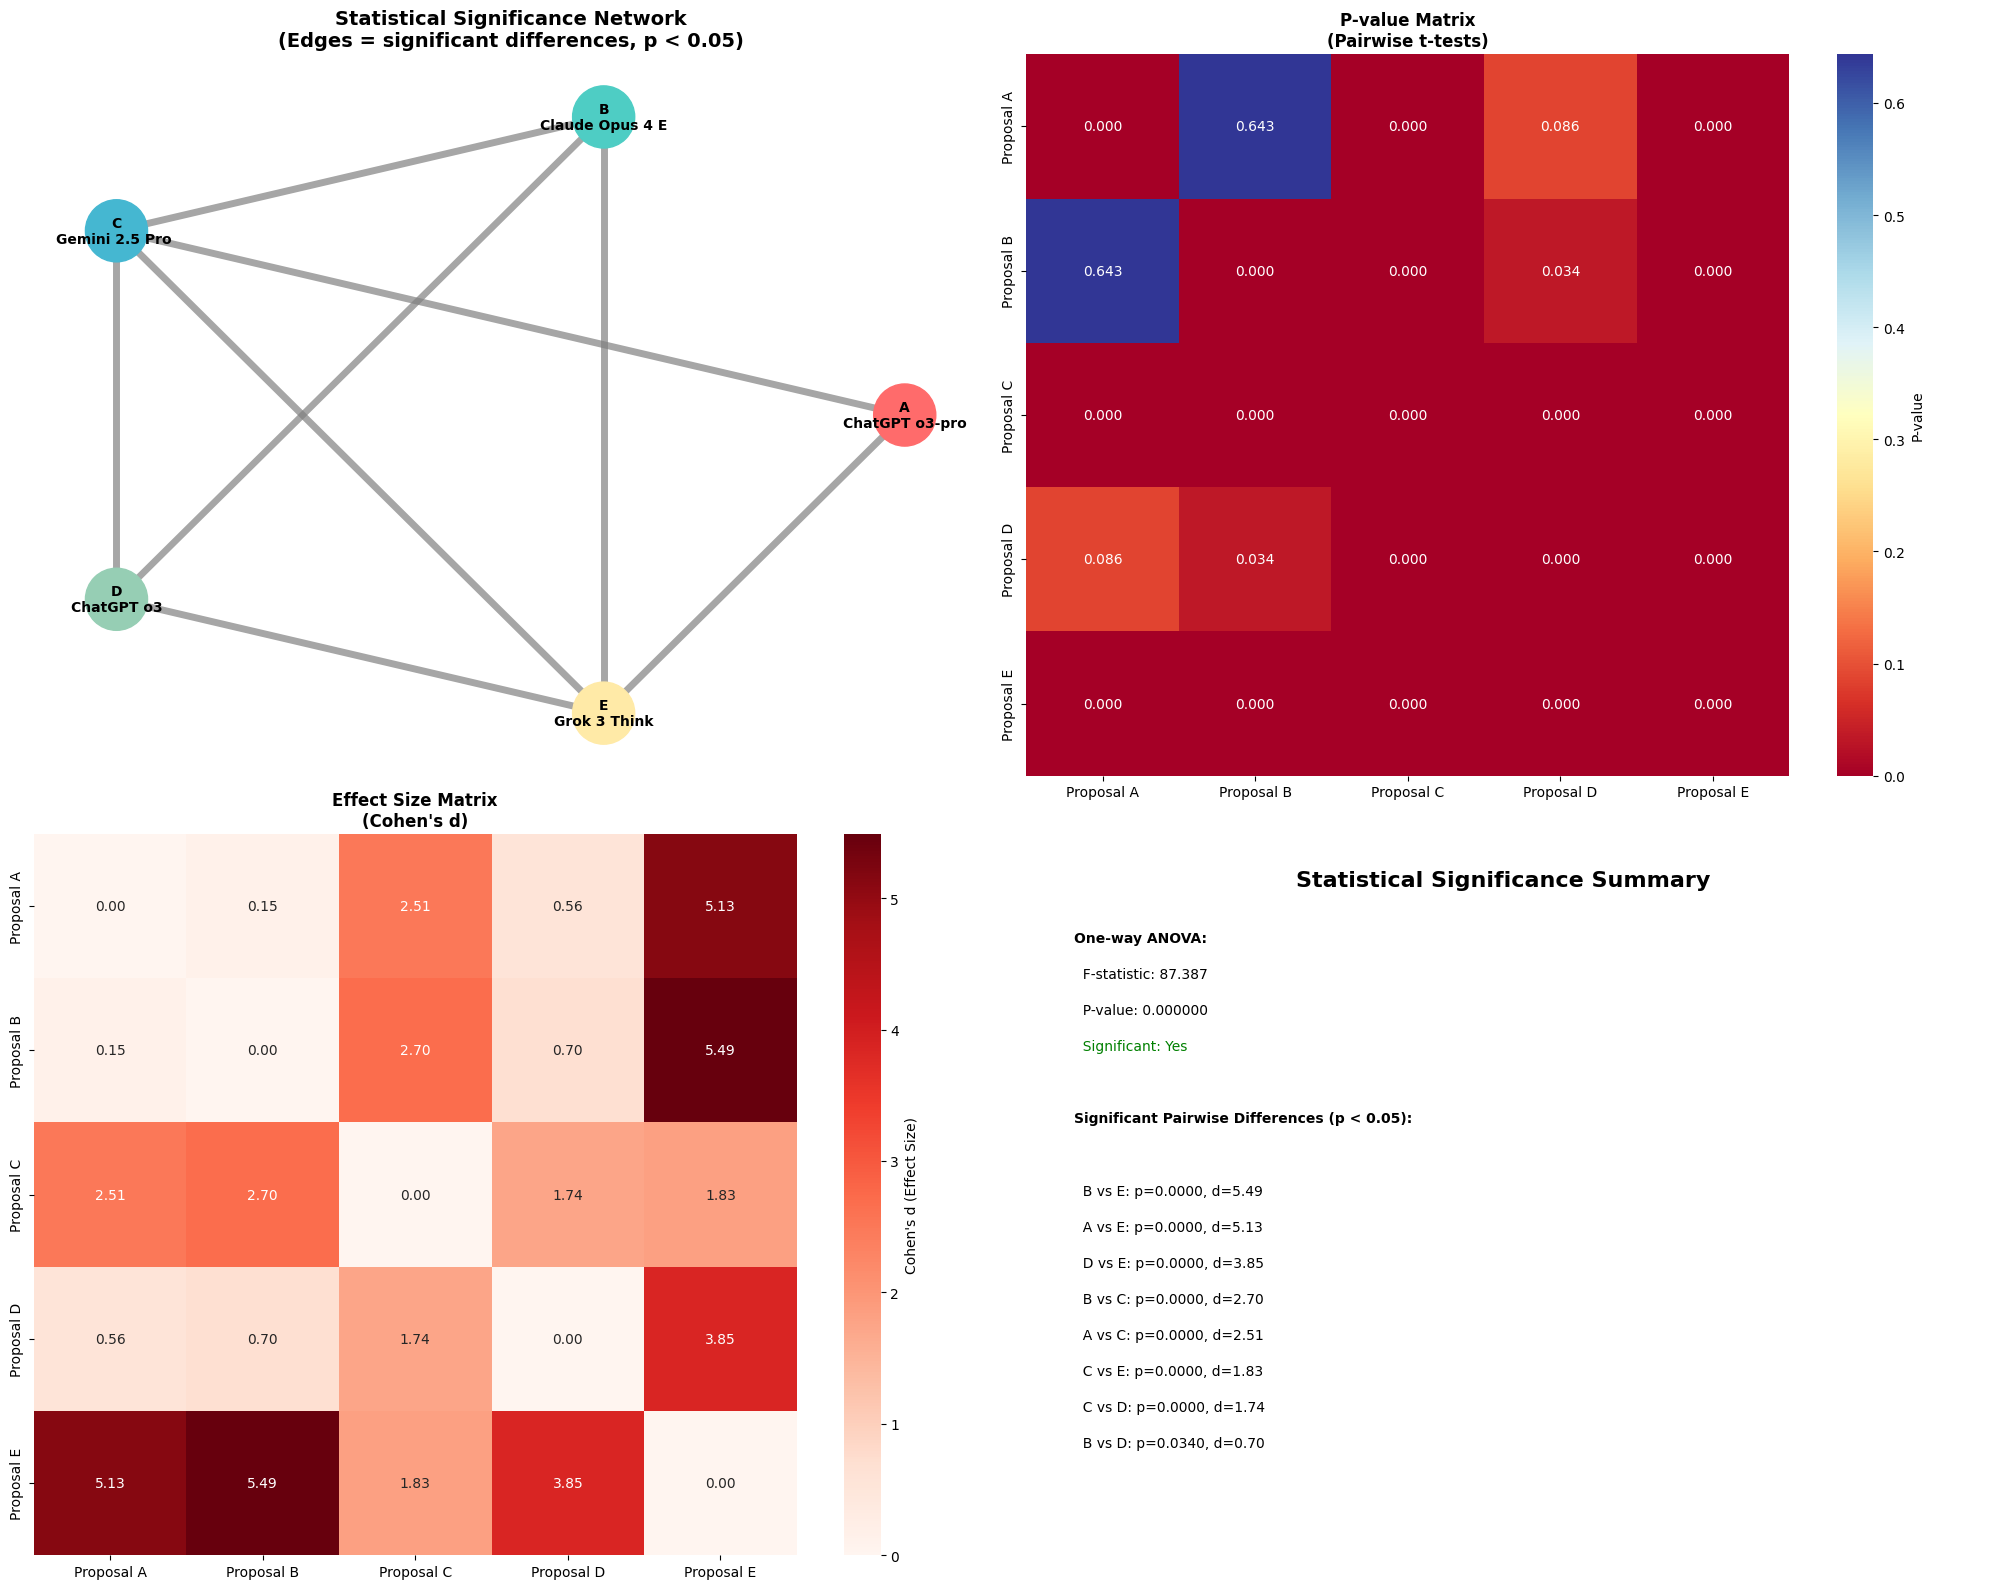

Statistical Significance Analysis:
One-way ANOVA: F(4, 95) = 87.387, p = 0.000000

Significant Pairwise Comparisons (p < 0.05):
------------------------------------------------------------
B (9.16) vs E (5.96): p=0.0000, Cohen's d=5.49
A (9.09) vs E (5.96): p=0.0000, Cohen's d=5.13
D (8.73) vs E (5.96): p=0.0000, Cohen's d=3.85
B (9.16) vs C (7.36): p=0.0000, Cohen's d=2.70
A (9.09) vs C (7.36): p=0.0000, Cohen's d=2.51
C (7.36) vs E (5.96): p=0.0000, Cohen's d=1.83
C (7.36) vs D (8.73): p=0.0000, Cohen's d=1.74
B (9.16) vs D (8.73): p=0.0340, Cohen's d=0.70


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import ttest_ind, f_oneway
from itertools import combinations

# Organize all individual scores by proposal for statistical testing
proposal_all_scores = {
    'A': [9.5, 9.5, 9.0, 8.5, 8.5, 9.5, 8.5, 8.0, 9.5, 10.0, 9.0, 9.5, 9.5, 9.5, 9.0, 8.8, 9.0, 9.5, 9.0, 8.5],
    'B': [9.0, 9.0, 8.5, 9.0, 9.5, 9.0, 9.5, 8.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 9.2, 8.4, 9.0, 9.0, 9.0, 9.5],
    'C': [7.5, 8.0, 7.5, 7.0, 7.0, 7.5, 7.0, 6.5, 7.0, 8.5, 6.0, 5.5, 7.3, 7.6, 7.1, 6.7, 8.5, 8.5, 8.5, 8.0],
    'D': [8.5, 9.0, 9.5, 8.0, 8.0, 8.5, 8.0, 7.5, 9.8, 9.5, 10.0, 9.8, 9.0, 9.0, 9.2, 8.4, 8.0, 8.0, 8.0, 9.0],
    'E': [6.0, 6.5, 6.0, 5.5, 5.5, 6.0, 5.5, 5.0, 5.0, 6.0, 5.0, 5.0, 6.1, 6.4, 6.0, 5.6, 7.0, 7.0, 7.0, 7.0]
}

# Calculate pairwise statistical significance
significance_matrix = np.zeros((5, 5))
p_value_matrix = np.zeros((5, 5))
effect_size_matrix = np.zeros((5, 5))

proposals_list = ['A', 'B', 'C', 'D', 'E']

for i, prop1 in enumerate(proposals_list):
    for j, prop2 in enumerate(proposals_list):
        if i != j:
            scores1 = proposal_all_scores[prop1]
            scores2 = proposal_all_scores[prop2]

            # Perform t-test
            t_stat, p_value = ttest_ind(scores1, scores2)
            p_value_matrix[i, j] = p_value

            # Calculate effect size (Cohen's d)
            mean1, mean2 = np.mean(scores1), np.mean(scores2)
            std1, std2 = np.std(scores1, ddof=1), np.std(scores2, ddof=1)
            pooled_std = np.sqrt(((len(scores1)-1)*std1**2 + (len(scores2)-1)*std2**2) /
                               (len(scores1) + len(scores2) - 2))
            cohens_d = (mean1 - mean2) / pooled_std
            effect_size_matrix[i, j] = abs(cohens_d)

            # Significance at p < 0.05
            significance_matrix[i, j] = 1 if p_value < 0.05 else 0

# Create network graph
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Significance Network Graph
G = nx.Graph()
pos = {}

# Add nodes
for i, prop in enumerate(proposals_list):
    G.add_node(prop)
    angle = 2 * np.pi * i / len(proposals_list)
    pos[prop] = (np.cos(angle), np.sin(angle))

# Add edges for significant differences
for i in range(len(proposals_list)):
    for j in range(i+1, len(proposals_list)):
        if significance_matrix[i, j] == 1 or significance_matrix[j, i] == 1:
            # Use the minimum p-value for edge weight
            p_val = min(p_value_matrix[i, j], p_value_matrix[j, i])
            G.add_edge(proposals_list[i], proposals_list[j], weight=1-p_val)

# Draw network
node_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, ax=ax1)
nx.draw_networkx_labels(G, pos,
                       labels={prop: f'{prop}\n{model_names[prop][:15]}' for prop in proposals_list},
                       font_size=10, font_weight='bold', ax=ax1)

# Draw edges with thickness based on significance
edges = G.edges(data=True)
for edge in edges:
    i, j = proposals_list.index(edge[0]), proposals_list.index(edge[1])
    p_val = min(p_value_matrix[i, j], p_value_matrix[j, i])
    thickness = max(1, 5 * (1 - p_val))  # Thicker for more significant
    nx.draw_networkx_edges(G, pos, [(edge[0], edge[1])], width=thickness,
                          alpha=0.7, edge_color='gray', ax=ax1)

ax1.set_title('Statistical Significance Network\n(Edges = significant differences, p < 0.05)',
              fontsize=14, fontweight='bold')
ax1.axis('off')

# 2. P-value heatmap
sns.heatmap(p_value_matrix,
            xticklabels=[f"Proposal {p}" for p in proposals_list],
            yticklabels=[f"Proposal {p}" for p in proposals_list],
            annot=True, fmt='.3f', cmap='RdYlBu',
            cbar_kws={'label': 'P-value'}, ax=ax2)
ax2.set_title('P-value Matrix\n(Pairwise t-tests)', fontweight='bold')

# 3. Effect size heatmap
sns.heatmap(effect_size_matrix,
            xticklabels=[f"Proposal {p}" for p in proposals_list],
            yticklabels=[f"Proposal {p}" for p in proposals_list],
            annot=True, fmt='.2f', cmap='Reds',
            cbar_kws={'label': "Cohen's d (Effect Size)"}, ax=ax3)
ax3.set_title("Effect Size Matrix\n(Cohen's d)", fontweight='bold')

# 4. Statistical summary
ax4.axis('off')
ax4.text(0.5, 0.95, 'Statistical Significance Summary',
         ha='center', va='top', fontsize=16, fontweight='bold', transform=ax4.transAxes)

# ANOVA test
all_scores = [proposal_all_scores[prop] for prop in proposals_list]
f_stat, p_anova = f_oneway(*all_scores)

y_pos = 0.85
ax4.text(0.05, y_pos, f'One-way ANOVA:', fontweight='bold', transform=ax4.transAxes)
ax4.text(0.05, y_pos-0.05, f'  F-statistic: {f_stat:.3f}', transform=ax4.transAxes)
ax4.text(0.05, y_pos-0.1, f'  P-value: {p_anova:.6f}', transform=ax4.transAxes)
ax4.text(0.05, y_pos-0.15, f'  Significant: {"Yes" if p_anova < 0.05 else "No"}',
         color='green' if p_anova < 0.05 else 'red', transform=ax4.transAxes)

y_pos -= 0.25
ax4.text(0.05, y_pos, 'Significant Pairwise Differences (p < 0.05):',
         fontweight='bold', transform=ax4.transAxes)

y_pos -= 0.05
sig_pairs = []
for i in range(len(proposals_list)):
    for j in range(i+1, len(proposals_list)):
        p_val = min(p_value_matrix[i, j], p_value_matrix[j, i])
        if p_val < 0.05:
            effect = abs(effect_size_matrix[i, j])
            sig_pairs.append((proposals_list[i], proposals_list[j], p_val, effect))

# Sort by p-value
sig_pairs.sort(key=lambda x: x[2])

for pair in sig_pairs[:8]:  # Show top 8 most significant
    y_pos -= 0.05
    ax4.text(0.05, y_pos,
             f'  {pair[0]} vs {pair[1]}: p={pair[2]:.4f}, d={pair[3]:.2f}',
             transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# Print detailed statistical summary
print("Statistical Significance Analysis:")
print("=" * 60)
print(f"One-way ANOVA: F({len(proposals_list)-1}, {sum(len(scores) for scores in all_scores)-len(proposals_list)}) = {f_stat:.3f}, p = {p_anova:.6f}")
print("\nSignificant Pairwise Comparisons (p < 0.05):")
print("-" * 60)
for pair in sig_pairs:
    prop1_mean = np.mean(proposal_all_scores[pair[0]])
    prop2_mean = np.mean(proposal_all_scores[pair[1]])
    print(f"{pair[0]} ({prop1_mean:.2f}) vs {pair[1]} ({prop2_mean:.2f}): p={pair[2]:.4f}, Cohen's d={pair[3]:.2f}")